# Simple Convergence Tests
**by <span style="color:darkgreen">Pablo Garcia Risueno</span> & <span style="color:darkgreen">Pasquale Pavone</span> for [<span style="color:darkgoldenrod">exciting *neon*</span>](https://www.exciting-code.org/neon)**

<font size="2">(Jupyter notebook by <span style="color:darkgreen">Mara Voiculescu</span> & <span style="color:darkgreen">Martin Kuban</span>)</font>
<hr style="border:2px solid #DDD"> </hr>

**<span style="color:firebrick">Purpose</span>**: In this tutorial, you will investigate how the choice of computational parameters can affect the result of an **`exciting`** calculation. The procedure which is used in this case is often called **convergence study** and allows to obtain the best value of such parameters. Explicit examples are presented for the convergence of the total energy of silver and diamond with respect to the choice for the **k**-points sampling (related to the parameter <code><span style="color:MediumBlue">ngridk</span></code>) and the dimension of the basis set (related to the parameter <code><span style="color:MediumBlue">rgkmax</span></code>).
<hr style="border:2px solid #DDD"> </hr>

<div class="alert alert-block alert-warning">

**Table of Contents**

[0. Before Starting](#0)
    
[1. Convergence of Total-Energy Calculations](#1)
   - The mesh of k-points
   - The basis-set size
   - Scaling of the calculation time  
    
[2. Running Tests: Silver](#2)  
   - Using scripts for checking convergence
   - How to quantify convergence    

[3. Running Tests: Diamond](#3)
    
[4. Final Questions](#4)
</div>

<a id='0'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">0. Before Starting</span>

**<span style="color:firebrick">Read the following paragraphs before starting with the rest of this tutorial!</span>**

Before running any Jupyter tutorials, please refer to the **`00_before_starting.md`** document on how to correctly set up the environment. This only needs to be done once. After which, the **venv** can be (re)activated from **`exciting`**'s root directory:

<div style="background-color: rgb(224, 224, 224);">

```bash
source tools/excitingjupyter/venv/excitingvenv/bin/activate
```

</div>

 Here is a list of the scripts found within the **`excitingscripts`** module which are relevant for this tutorial with a short description.

* **`setup.convergence_test.py`**: Python script for generating input files with different values of the main computational parameters.

* **`execute.convergence_test.py`**: Python script for running a series of exciting calculations.

* **`plot.convergence.py`**: Python script for visualization of convergence results.

As a first step, you may set the **exciting_root** directory and create a running directory for the notebook.

In [1]:
%%bash
mkdir -p run_simple_convergence_tests

<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">1. Convergence of Total-Energy Calculations</span>
A ground-state calculation using a **DFT** code like **`exciting`** fundamentally depends on 2 parameters

- the mesh of **k**-points (<code><span style="color:green">groundstate</span></code> attribute: <code><span style="color:mediumblue">ngridk</span></code>);
- the size of the basis set for expanding the wave function (<code><span style="color:green">groundstate</span></code> attribute: <code><span style="color:mediumblue">rgkmax</span></code>).

In order to be able to rely on your calculation, you need to understand what these two parameters mean and what is the effect of a change of their values **<span style="color:firebrick">on the physical quantities which are relevant for you</span>**. In this tutorial, we focus on the effect of such changes on the total energy of a crystal **<span style="color:firebrick">only for pedagogical reasons</span>**. In the general case, this kind of analysis **<span style="color:firebrick">must</span>** be made for all the properties of interest (*e.g.*, **lattice parameters**, **bulk modulus**, **equation of state**, **bandgap energies**, *etc.*).

For more informations on these parameters, please expand the links below.
<hr style="border:1px solid #DDD"> </hr>
<details>
    
<summary><strong><span style="color:firebrick">$\Rightarrow$ Read more on the mesh of k-points</span></strong></summary>
    
**<span style="color:#15317E">The mesh of k-points</span>**
    
From basic considerations of solid-state theory, it can be shown that the Schrödinger (or, in our case, Kohn-Sham) equation for a periodic system has a bunch of solutions, where each solution is characterized by a vector **k** in reciprocal space. This **k**-vector is essentially related to the periodicity of the corresponding solution of the Schrödinger equation: Roughly speaking, the solution will have the same value at coordinates in real space that, along the direction of **k**, have a distance of 2$\pi$/|**k**|.

Many properties of a solid, including the total energy, are represented as integrals, performed over all possible **k**-vectors. Obviously, the direct calculation of these integrals is very demanding (one should calculate the solution of the Schrödinger equation for a **huge** number of **k**-points). Therefore, the integrals are approximated by sums performed on a set of **k**-points distributed on a finite grid. The **spacing** of the points on the grid is a measure of the accuracy of the calculation of the integrals which also depends on how fast the integrand (the solution of the Schrödinger equation) varies by changing k. The challenge is to find a good number of **k**-points: Large enough to capture the physical properties of your system well, but small enough to keep calculations as fast as possible.

Some qualitative considerations:

- The larger the unit cell, the smaller is the required **k**-point mesh.
- Systems with longer-range interactions need larger k-point meshes.
    - In **<span style="color:firebrick">metals</span>** you need a large number of **k**-points, since the conduction electrons are delocalized over the whole system, i.e. the interactions are very long-ranged. Moreover, for a good description of the system it is important to know exactly where the conduction bands cross the Fermi level, which also requires a dense **k** mesh.
    - In contrast, **<span style="color:firebrick">semiconductors and insulators</span>** usually have much more localized electronic states, and a gap between valence and conduction bands. Thus, the number of **k**-points required for a good calculation is much smaller.
    
In **`exciting`** the parameter which is associated to the choiche of the mesh of **k**-points is <code><span style="color:mediumblue">ngridk</span></code>, see [**<span style="color:#3366BB">Input Reference</span>**](http://exciting.wikidot.com/ref:groundstate#attngridk) for further details.
</details>
<hr style="border:1px solid #DDD"> </hr>
<details>
 
<summary><strong><span style="color:firebrick">$\Rightarrow$ Read more on the basis-set size </span></strong></summary>
    
**<span style="color:#15317E">The basis-set size</span>**

Most of the **DFT** codes solve the Kohn-Sham equation in reciprocal space, expanding the wavefunctions in terms of suitable periodic basis functions. In our case, the basis functions are the **linearized augmented plane waves (LAPW)**. The larger the size of the basis set, the more accurate is the calculation. The corresponding <code><span style="color:green">groundstate</span></code> attribute in the exciting code is <code><span style="color:mediumblue">rgkmax</span></code> (see [**<span style="color:#3366BB">Input Reference</span>**](http://exciting.wikidot.com/ref:groundstate#attrgkmax)). The default value of <code><span style="color:mediumblue">rgkmax</span></code> is 7.0. In some cases, (*e.g.*, for a good description of forces), larger values (8.0 — 9.0) may be necessary to get reliable results. In some other cases, (*e.g.*, for describing very light materials like hydrogen), already smaller values of <code><span style="color:mediumblue">rgkmax</span></code> may be sufficient.
</details>
<hr style="border:1px solid #DDD"> </hr>
<details>
    
<summary><span style="color:firebrick"><strong>$\Rightarrow$ Read more on the scaling of the calculation time</strong></span></summary>
    
**<span style="color:#15317E">Scaling of the calculation time</span>**
    
The calculation time scales
- linearly with respect to the number of *k*-points;
- as <code><span style="color:mediumblue">rgkmax</span></code> to the power of **<span style="color:firebrick">9</span>**.
</details>

<a id='2'></a>
<hr style="border:1px solid #DDD"> </hr>  

### <span style="color:#15317E">2. Running Tests: Silver</span>

In this first example, we investigate the dependence of the total energy on the parameters <code><span style="color:mediumblue">ngridk</span></code> and <code><span style="color:mediumblue">rgkmax</span></code> for the Ag crystal.
We start by creating an **`exciting`** (**xml**) input file called **input.xml** which should appear as the one below.

<span class="SILVER_CONVERGENCE_INPUT"></span>
```xml
<input>

   <title>Ag: Convergence test</title>

   <structure speciespath="$EXCITINGROOT/species">

      <crystal scale="7.7201">
         <basevect>0.5 0.5 0.0</basevect>
         <basevect>0.5 0.0 0.5</basevect>
         <basevect>0.0 0.5 0.5</basevect>
      </crystal>

      <species speciesfile="Ag.xml">
         <atom coord="0.0  0.0  0.0" />
      </species>

   </structure>

   <groundstate
      xctype="GGA_PBE_SOL"
      ngridk="4 4 4"
      rgkmax="5.0">
   </groundstate>

</input>
```

The next step is writing the complete input as a string and saving it in your working directory as **input.xml**.

In [2]:
import os
from excitingjupyter.utilities import get_input_xml_from_notebook

# Extract input file content from this notebook:
input_str = get_input_xml_from_notebook("tutorial_simple_convergence_tests", "SILVER_CONVERGENCE_INPUT")

# Write out the input as an XML file:
with open(os.path.join(os.getcwd(), 'run_simple_convergence_tests/input.xml'), "w") as fid:
    fid.write(input_str)

**<span style="color:firebrick">N.B.</span>**: Do not forget to replace in the input.xml the string **"\$EXCITINGROOT"** by the actual value of the environment variable **$EXCITINGROOT** using the command

In [3]:
%%bash
cd run_simple_convergence_tests
python3 -m excitingscripts.setup.excitingroot
cd ..

In order to run **`exciting`** from the terminal, you simply need to execute the **exciting_smp** binary in the running directory. After a few seconds, the calculation should be finished.
Here we used the <code>time</code> command before **exciting_smp** in order to get, at the end of the run, the elapsed time explicitly written on the screen.

In [ ]:
%%bash
cd run_simple_convergence_tests
time $EXCITINGROOT/bin/exciting_smp input.xml
cd ..

After a few seconds, the calculation will be completed. Indeed, the calculation you have just performed uses very rough values for the parameters <code><span style="color:mediumblue">ngridk</span></code> and <code><span style="color:mediumblue">rgkmax</span></code>. The corresponding total energy (in Hartree) can be found as the last non empty line of the file **TOTENERGY.OUT**. You can save the value of parameters and total energy at a text file called **convergence-test** as indicated below (here, only the first value of the parameter <code><span style="color:mediumblue">ngridk</span></code> is considered).

```
4  5.0  -5314.29682116   # ngridk rgkmax  total-energy
```
In order to improve the calculation, we should change the value of <code><span style="color:mediumblue">ngridk</span></code> and <code><span style="color:mediumblue">rgkmax</span></code> and repeat the calculation in a systematic way. By changing the values in the input file of one (or both) parameters, *e.g.*

```xml
...
   <groundstate
      xctype="GGA_PBE_SOL" 
      ngridk="6 6 6" 
      rgkmax="5.0">
   </groundstate>
...

```
and performing a new calculation using the command **exciting_smp**, we can extract the value of the calculated total energy and add it to the file **convergence-test**, which now should appear as:
```
4  5.0  -5314.29682116   # ngridk rgkmax  total-energy
6  5.0  -5314.31785599
```
Then, the same procedure can be repeated for other values of the parameters.

#### <span style="color:#15317E">Using scripts for checking convergence</span>

The procedure described above can be easily performed with the help of some useful script. For instance, the script **`excitingscripts.setup.convergence_test`** can be used for preparing inputs for a sequence of calculations. You can execute the script in your running directory in the following way.

In [6]:
%%bash
cd run_simple_convergence_tests
python3 -m excitingscripts.setup.convergence_test 4 20 5 5
cd ..

where the first 2 arguments are the minimum and maximum values (**<span style="color:firebrick">with a step of 2</span>**) for <code><span style="color:mediumblue">ngridk</span></code>, respectively. The last 2 (**<span style="color:firebrick">integer!</span>**) entries are the minimum and maximum values (**<span style="color:firebrick">with a step of 1</span>**) for <code><span style="color:mediumblue">rgkmax</span></code>, respectively. This means that, in this example, we are considering the convergence of the total energy as a function of <code><span style="color:mediumblue">ngridk</span></code> at the constant value of <code><span style="color:mediumblue">rgkmax</span></code> = "5".

The complete run is performed by the script **`excitingscripts.execute.convergence_test`**.

In [7]:
%%bash
cd run_simple_convergence_tests
python3 -m excitingscripts.execute.convergence_test 4 20 5 5
cd ..

The result of this sequence of calculation is summarized automatically in the file **convergence-test**, which now should appear as:

In [8]:
!cat run_simple_convergence_tests/convergence-test 

   4    5.00      -5314.29682117
   6    5.00      -5314.31785599
   8    5.00      -5314.32020713
  10    5.00      -5314.31951739
  12    5.00      -5314.31699339
  14    5.00      -5314.31899811
  16    5.00      -5314.31931353
  18    5.00      -5314.31818236
  20    5.00      -5314.31905101


To visualize these results you can use the following command (the line entry **<span style="color:firebrick">k</span>** indicates the running on different values of <code><span style="color:mediumblue">ngridk</span></code>).

In [9]:
%%bash
cd run_simple_convergence_tests
python3 -m excitingscripts.plot.convergence k
cd ..

<figure>
<img src=" 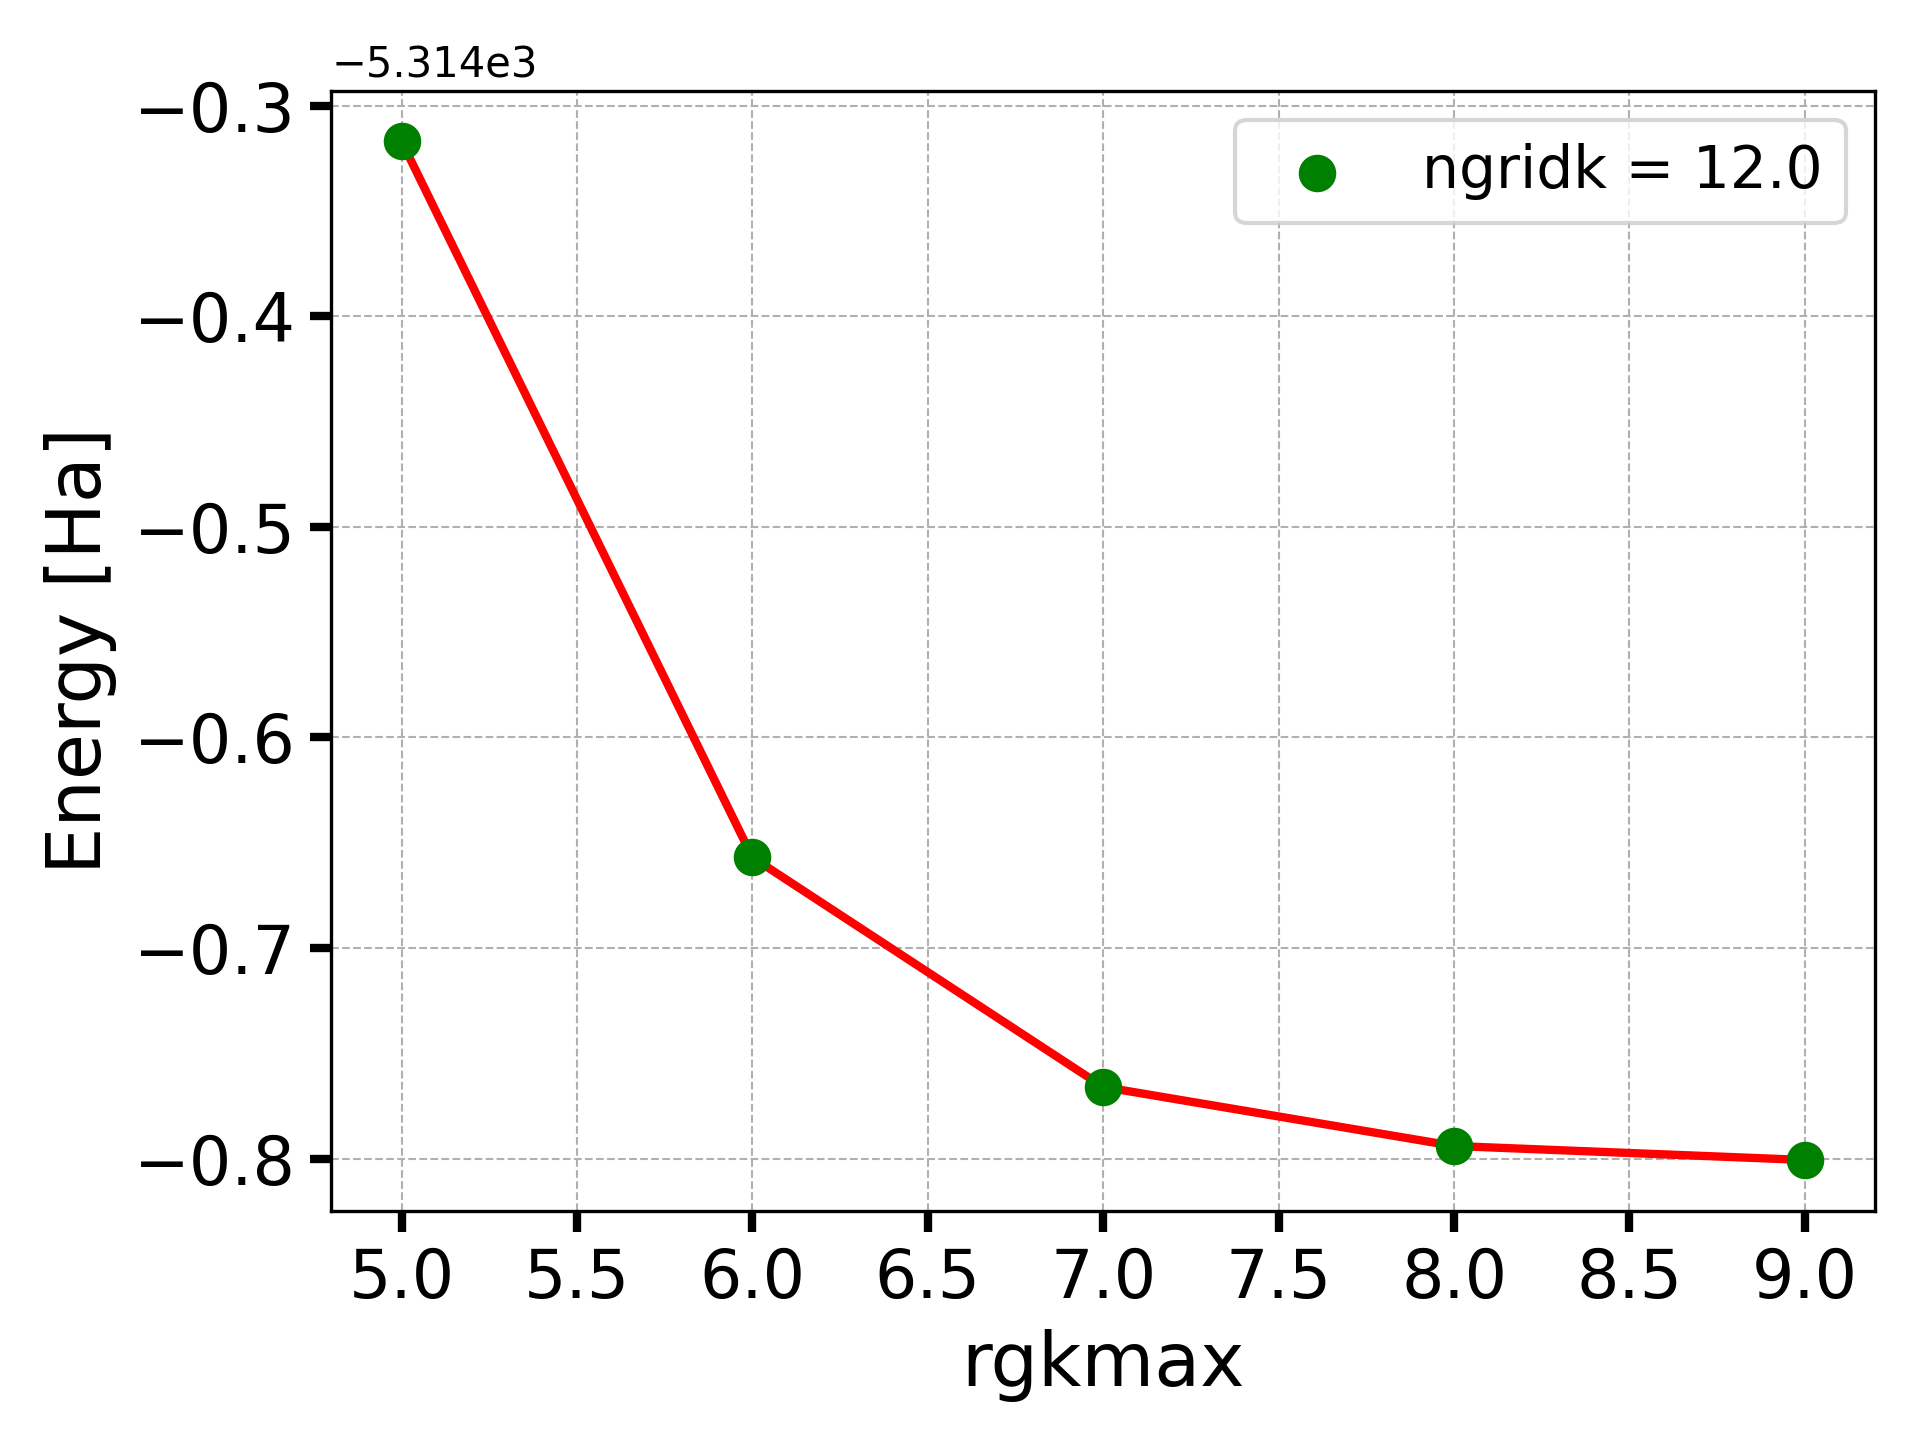" width="500" align="left"/>
</figure>

Then, you can use this procedure to plot the convergence for the following examples. In order to visualize the different results, we create a subdirectory for each of the examples.
- **<span style="color:darkgreen">Example 1</span>**: Run on  <code><span style="color:mediumblue">ngridk</span></code> at fixed <code><span style="color:mediumblue">rgkmax</span></code> = "9"

In [12]:
%%bash
cd run_simple_convergence_tests
mkdir -p silver_4_20_9_9 && cd silver_4_20_9_9
cp ../input.xml .
python3 -m excitingscripts.setup.convergence_test 4 20 9 9
python3 -m excitingscripts.execute.convergence_test 4 20 9 9
python3 -m excitingscripts.plot.convergence k
cd ../..

<figure>
<img src=" 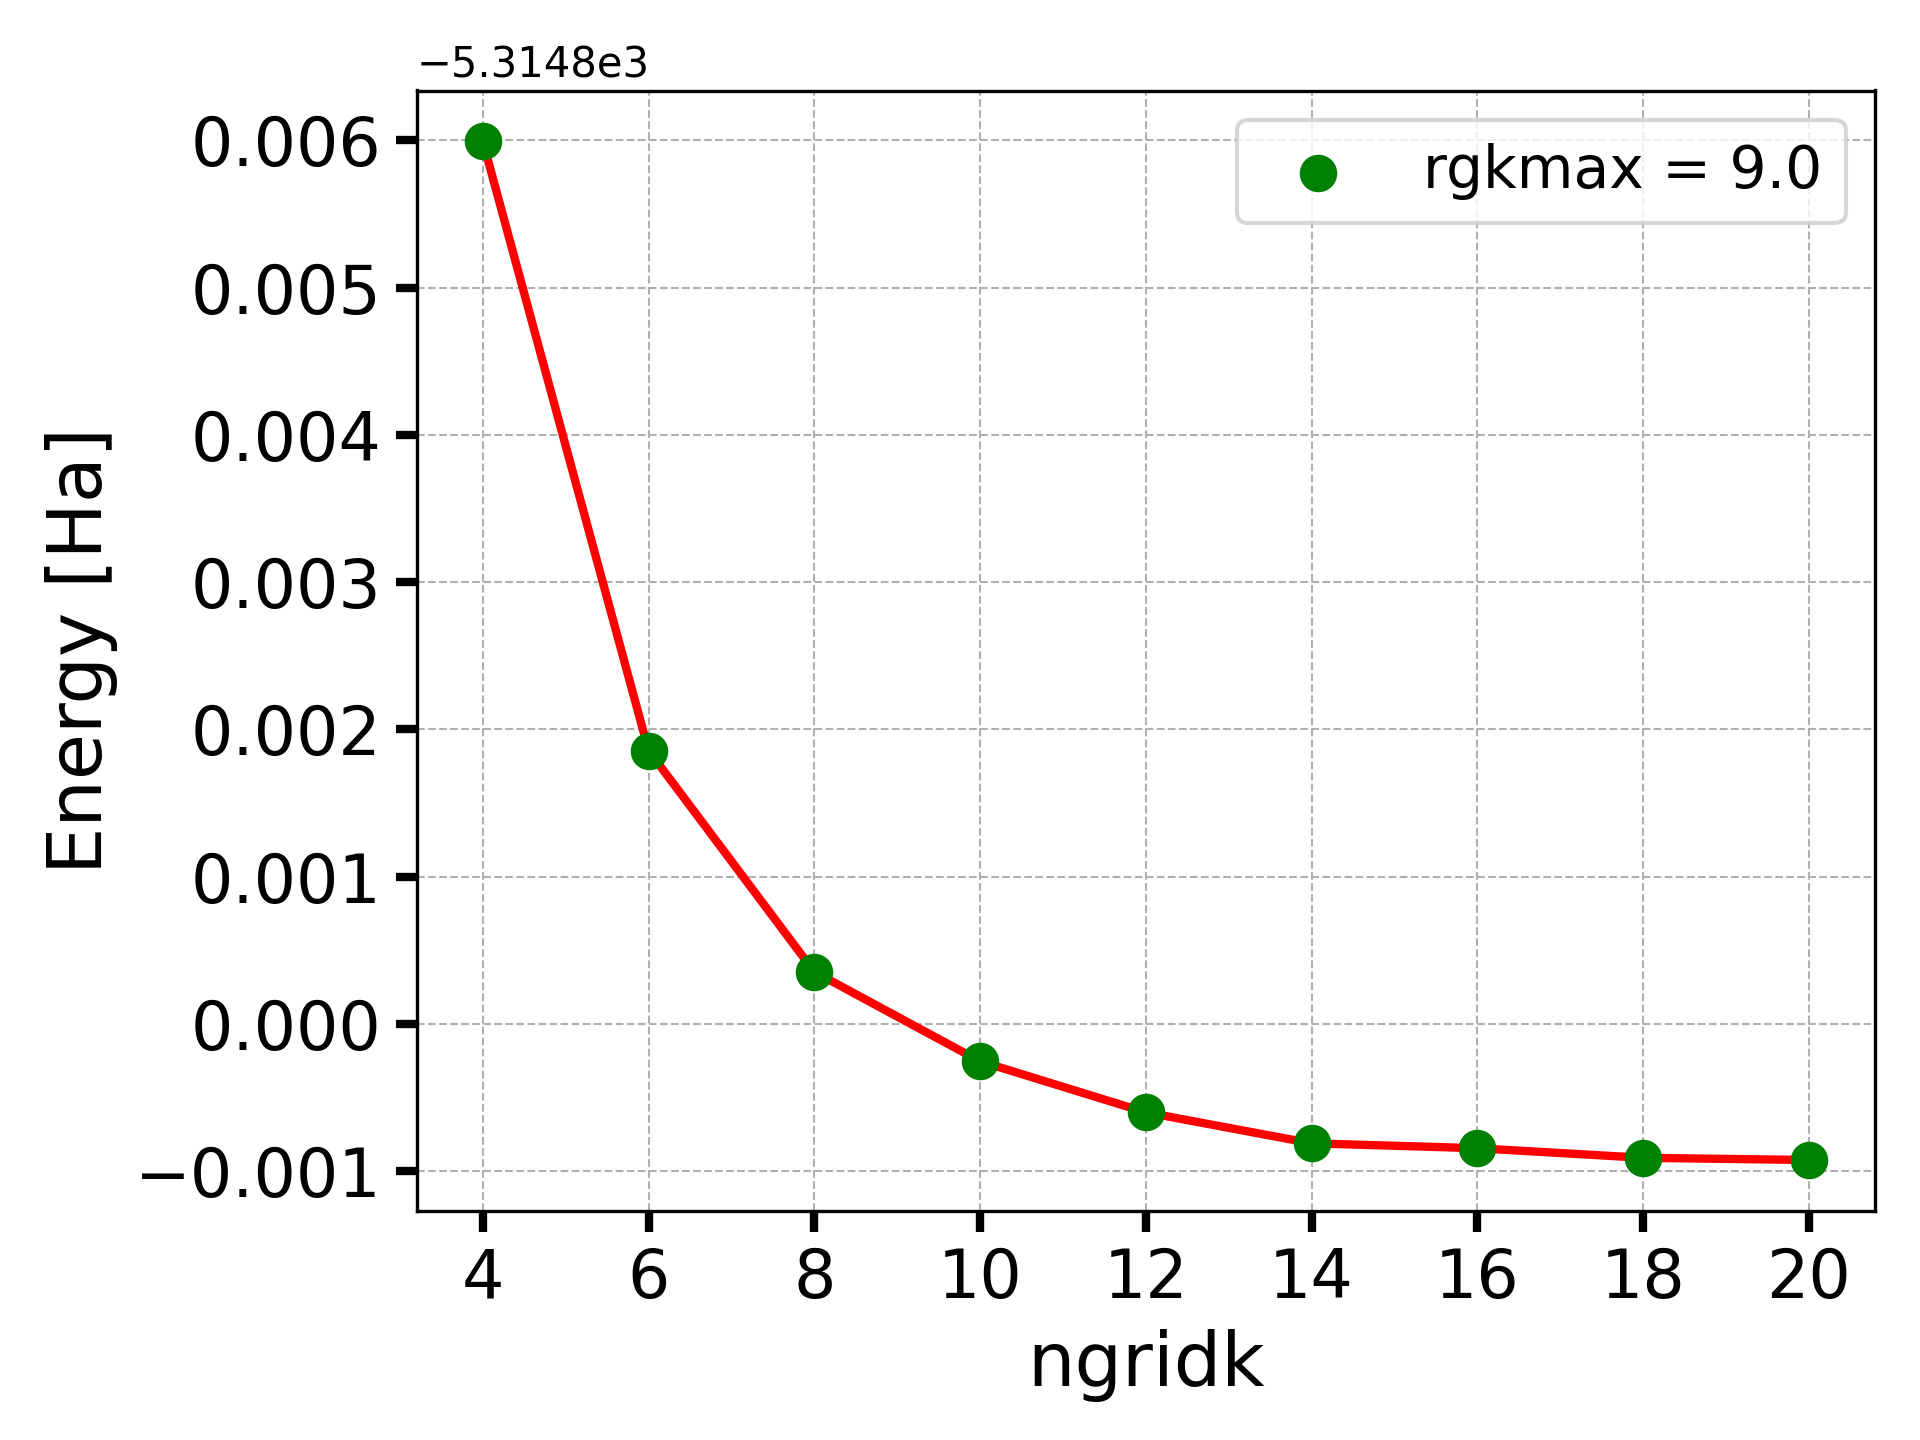" width="500" align="left"/>
</figure>

- **<span style="color:darkgreen">Example 2</span>**: Run on <code><span style="color:mediumblue">rgkmax</span></code> at fixed  <code><span style="color:mediumblue">ngridk</span></code> = "12 12 12"

In [16]:
%%bash
cd run_simple_convergence_tests
mkdir -p silver_12_12_5_9 && cd silver_12_12_5_9
cp ../input.xml .
python3 -m excitingscripts.setup.convergence_test 12 12 5 9
python3 -m excitingscripts.execute.convergence_test 12 12 5 9
python3 -m excitingscripts.plot.convergence r
cd ../..

<figure>
<img src=" 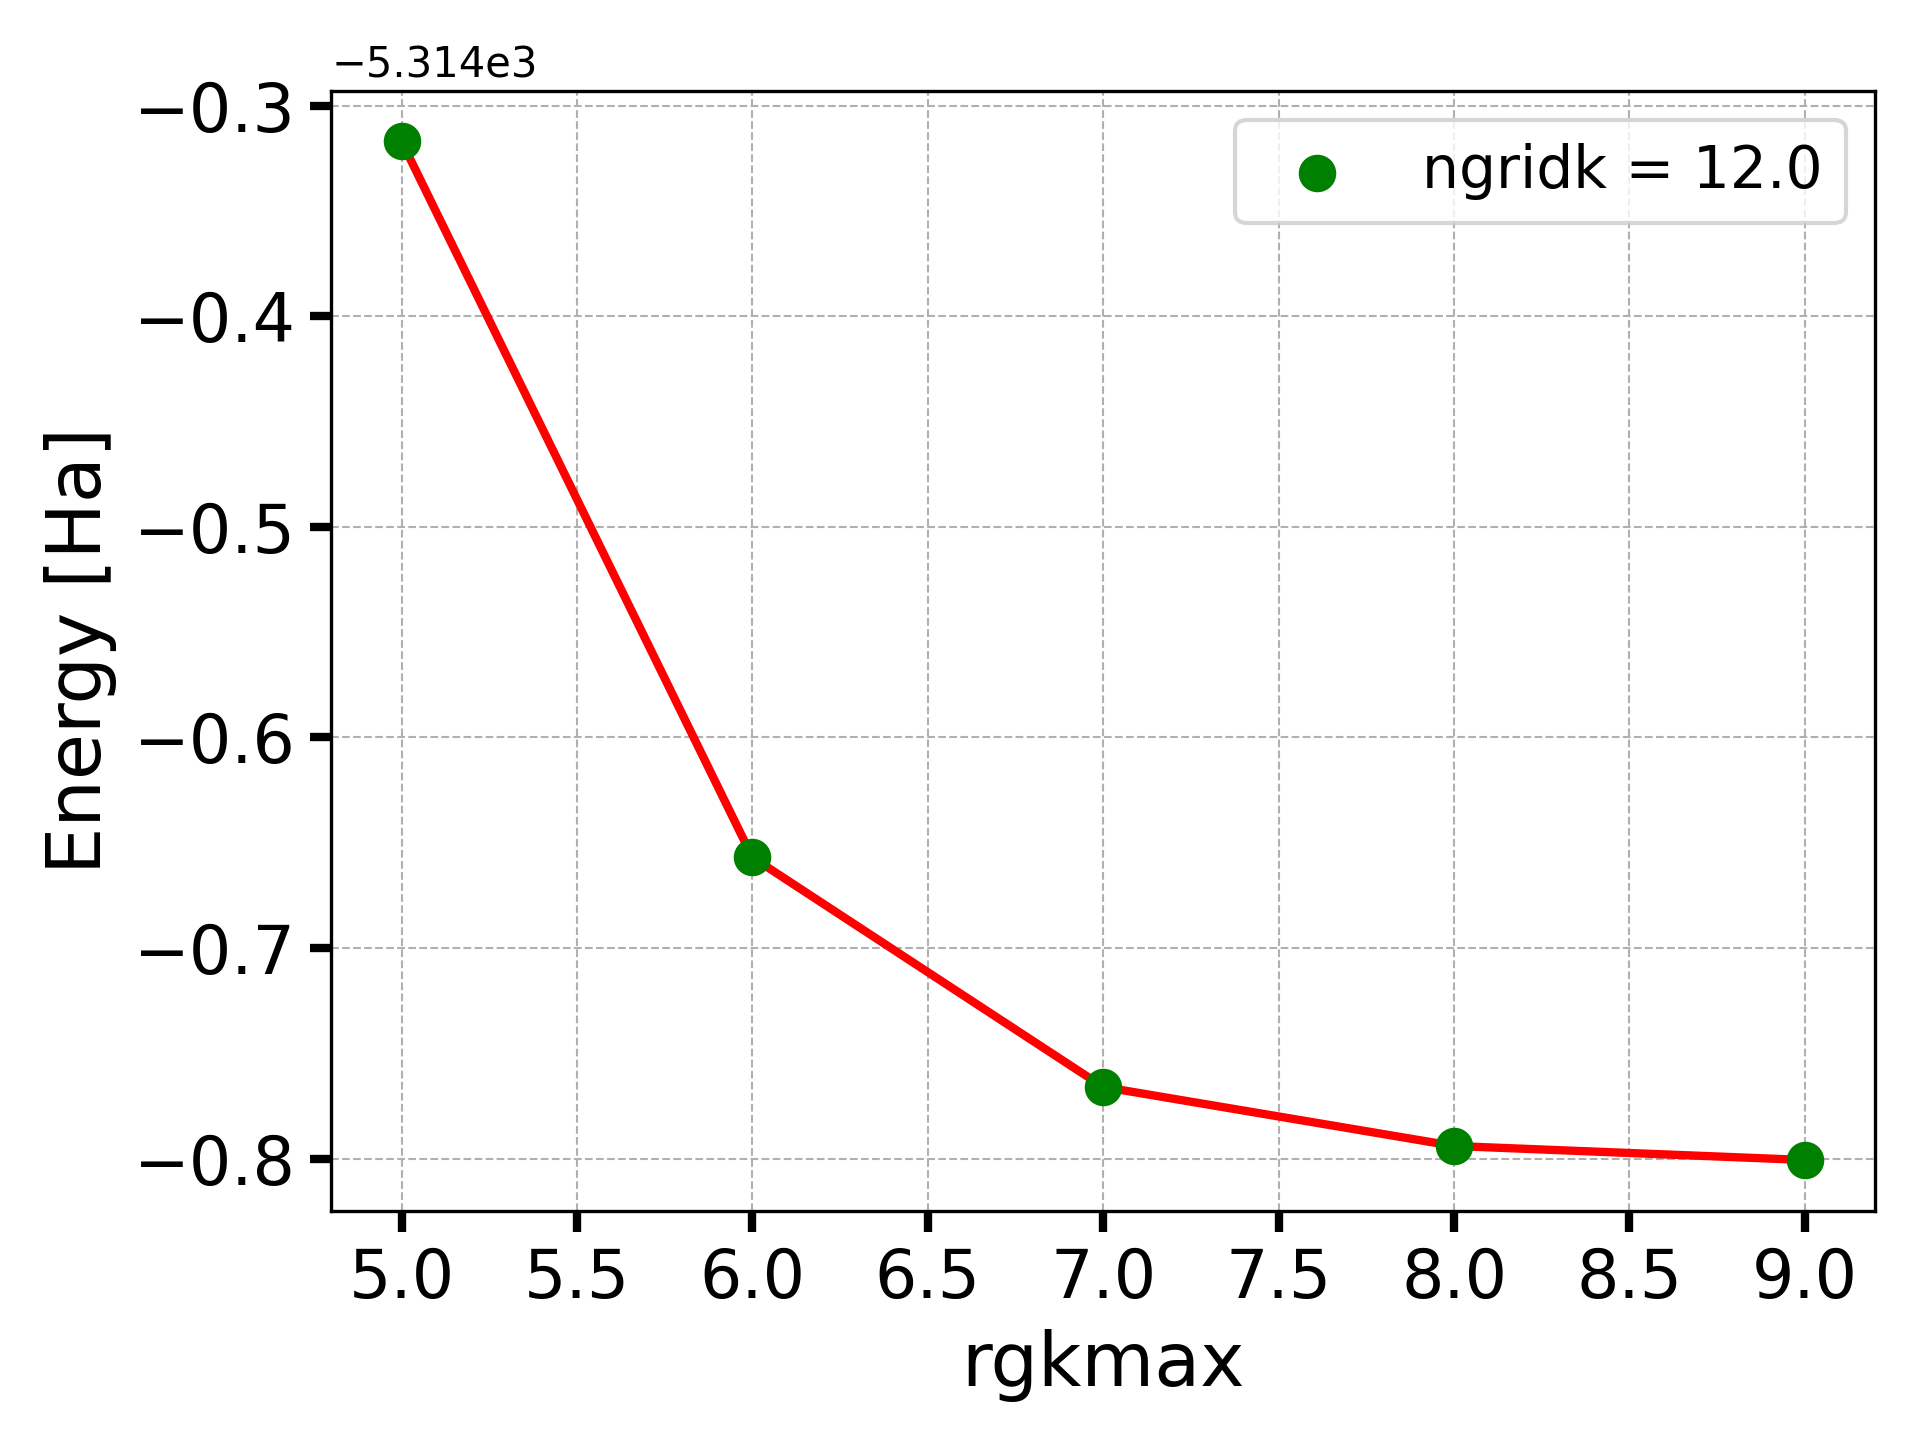" width="500" align="left"/>
</figure>

- **<span style="color:darkgreen">Example 3</span>**: Two-dimentional run on both <code><span style="color:mediumblue">rgkmax</span></code> and  <code><span style="color:mediumblue">ngridk</span></code>

In [18]:
%%bash
cd run_simple_convergence_tests
mkdir -p silver_4_20_5_9 && cd silver_4_20_5_9
cp ../input.xml .
python3 -m excitingscripts.setup.convergence_test 4 20 5 9
python3 -m excitingscripts.execute.convergence_test 4 20 5 9
python3 -m excitingscripts.plot.convergence rk
cd ../..

<figure>
<img src=" 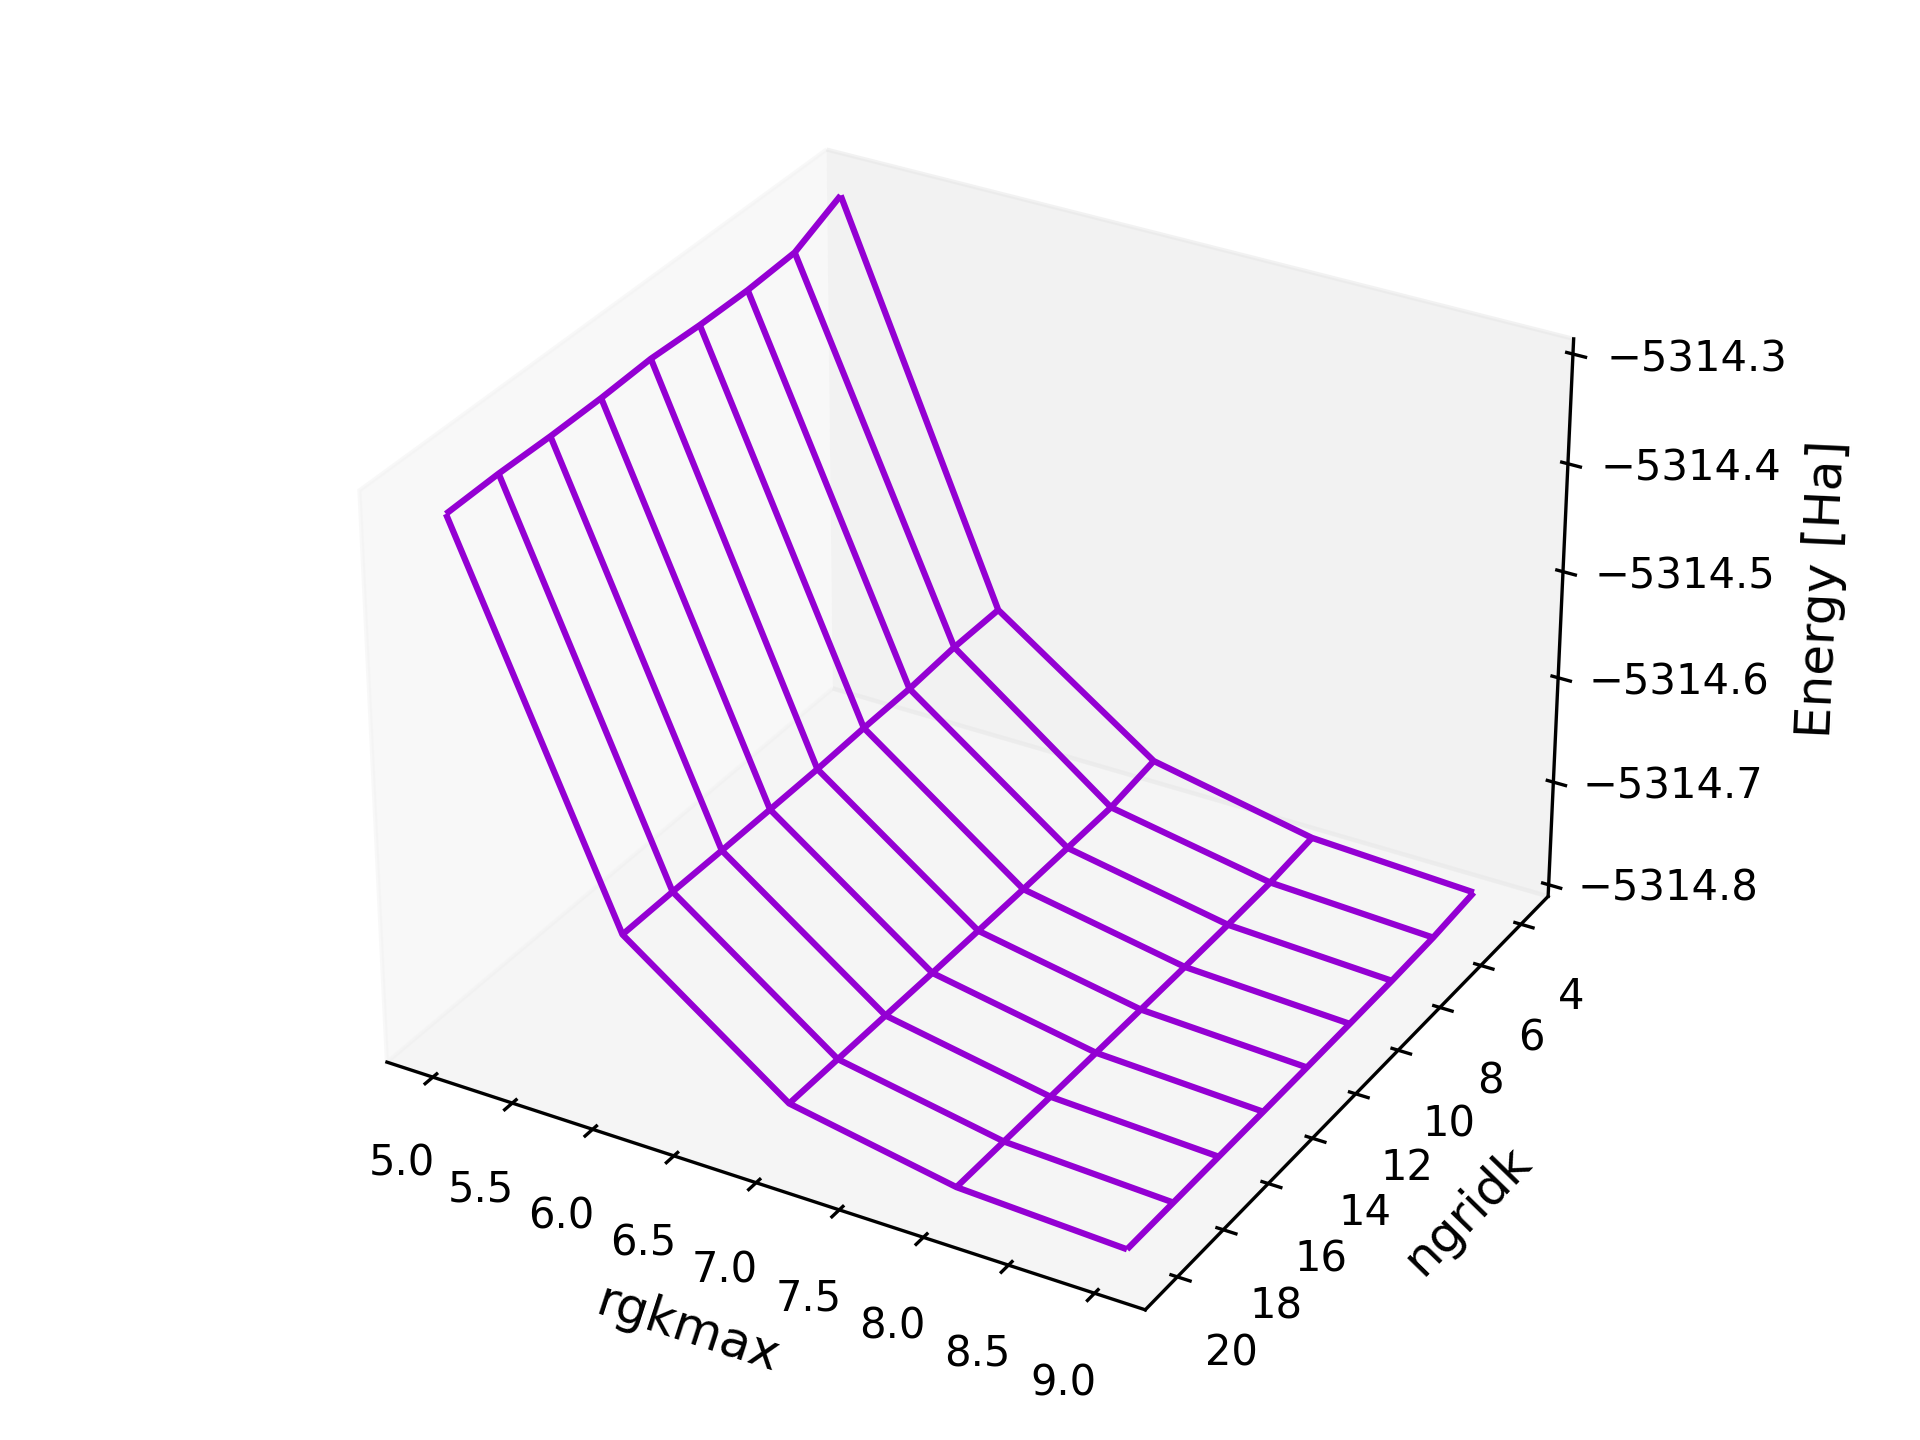" width="600" align="left"/>
</figure>

#### How to quantify convergence

In this subsection we refer to the results of **<span style="color:darkgreen">Example 1</span>**. In this case the **convergence-test** file is:

```
   4    9.00      -5314.79400821
   6    9.00      -5314.79814418
   8    9.00      -5314.79964620
  10    9.00      -5314.80025331
  12    9.00      -5314.80060003
  14    9.00      -5314.80081026
  16    9.00      -5314.80084371
  18    9.00      -5314.80090872
  20    9.00      -5314.80092356
```

Due to the fact that the difference between energies in contiguous rows becomes (increasingly) smaller going to large values of  <code><span style="color:mediumblue">ngridk</span></code>, this difference can be interpreted as a measure of the accuracy in the value of the calculated energy.

<hr style="border:1px solid #DDD"> </hr>
<a id='3'></a>

### <span style="color:#15317E">3. Running Tests: Diamond</span>

Repeat what you have done in the previous section for diamond. In contrast to silver, which is a metal, diamond an insulator. The corresponding input for **`exciting`** (**input.xml**) could look like the following.

```xml
<input>

   <title>Diamond: Convergence test</title>

   <structure speciespath="$EXCITINGROOT/species">

      <crystal scale="6.719">
         <basevect>0.5 0.5 0.0</basevect>
         <basevect>0.5 0.0 0.5</basevect>
         <basevect>0.0 0.5 0.5</basevect>
      </crystal>

      <species speciesfile="C.xml">
         <atom coord="0.00 0.00 0.00" />
         <atom coord="0.25 0.25 0.25" />
      </species>

   </structure>

   <groundstate
      xctype="GGA_PBE_SOL"
      ngridk="4 4 4"
      rgkmax="5.0"
      gmaxvr="14">
   </groundstate>

</input>
```

Finally, on the basis of what you learned above, try to reproduce the results for Diamond displayed in the following.

In [28]:
%%bash
cd reference_data_simple_convergence_tests/diamond_4_20_5_5
python3 -m excitingscripts.plot.convergence k
cd ../..

<figure>
<img src=" 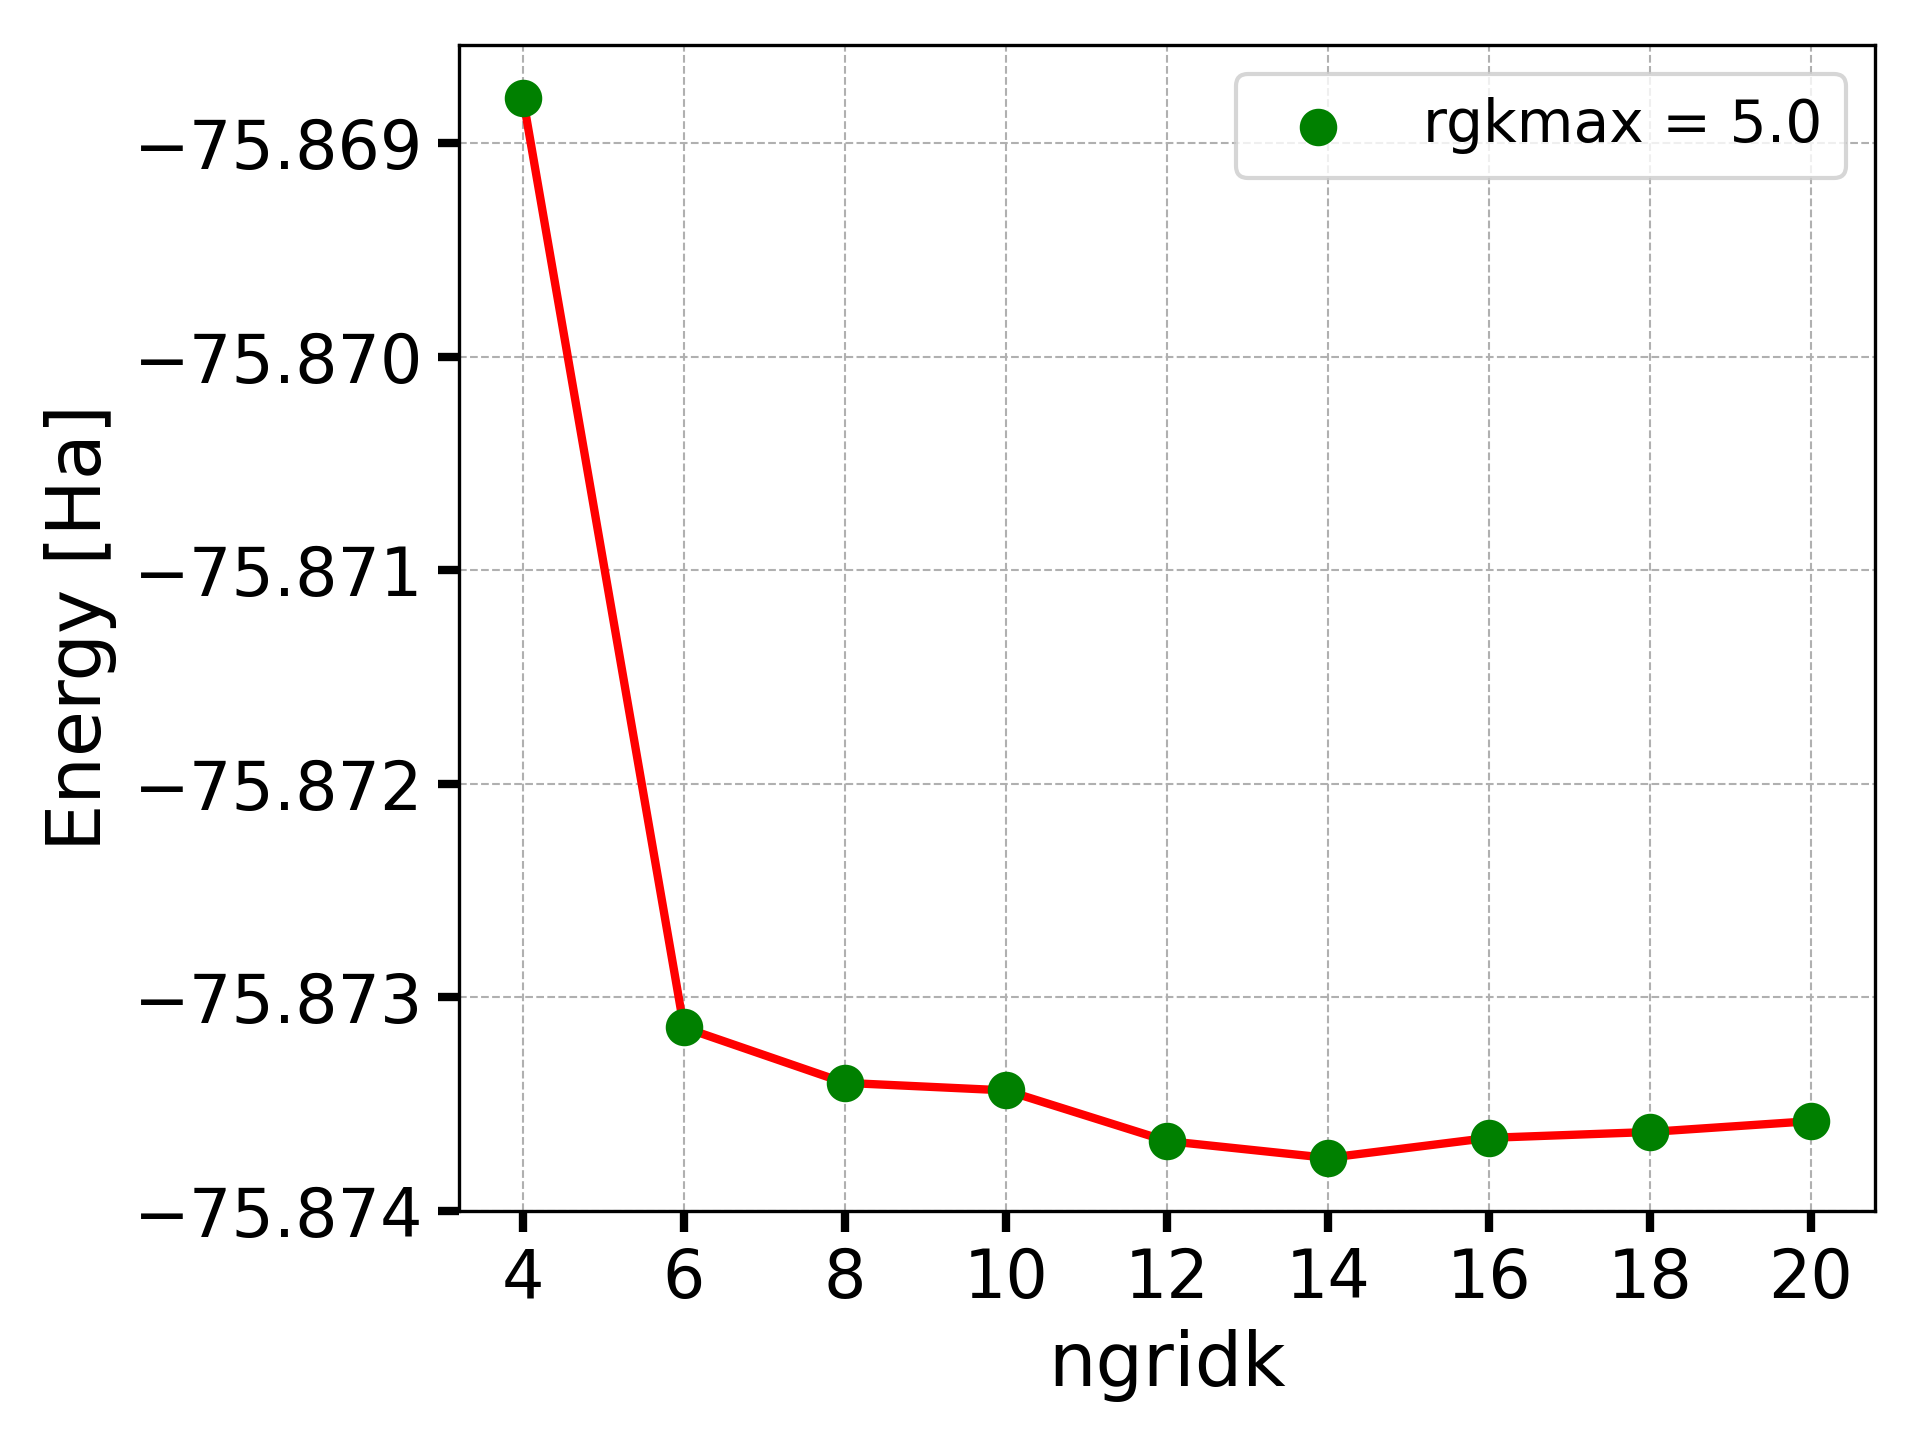" width="500" align="left"/>
</figure>

In [32]:
%%bash
cd reference_data_simple_convergence_tests/diamond_4_20_9_9
python3 -m excitingscripts.plot.convergence k
cd ../..

<figure>
<img src=" 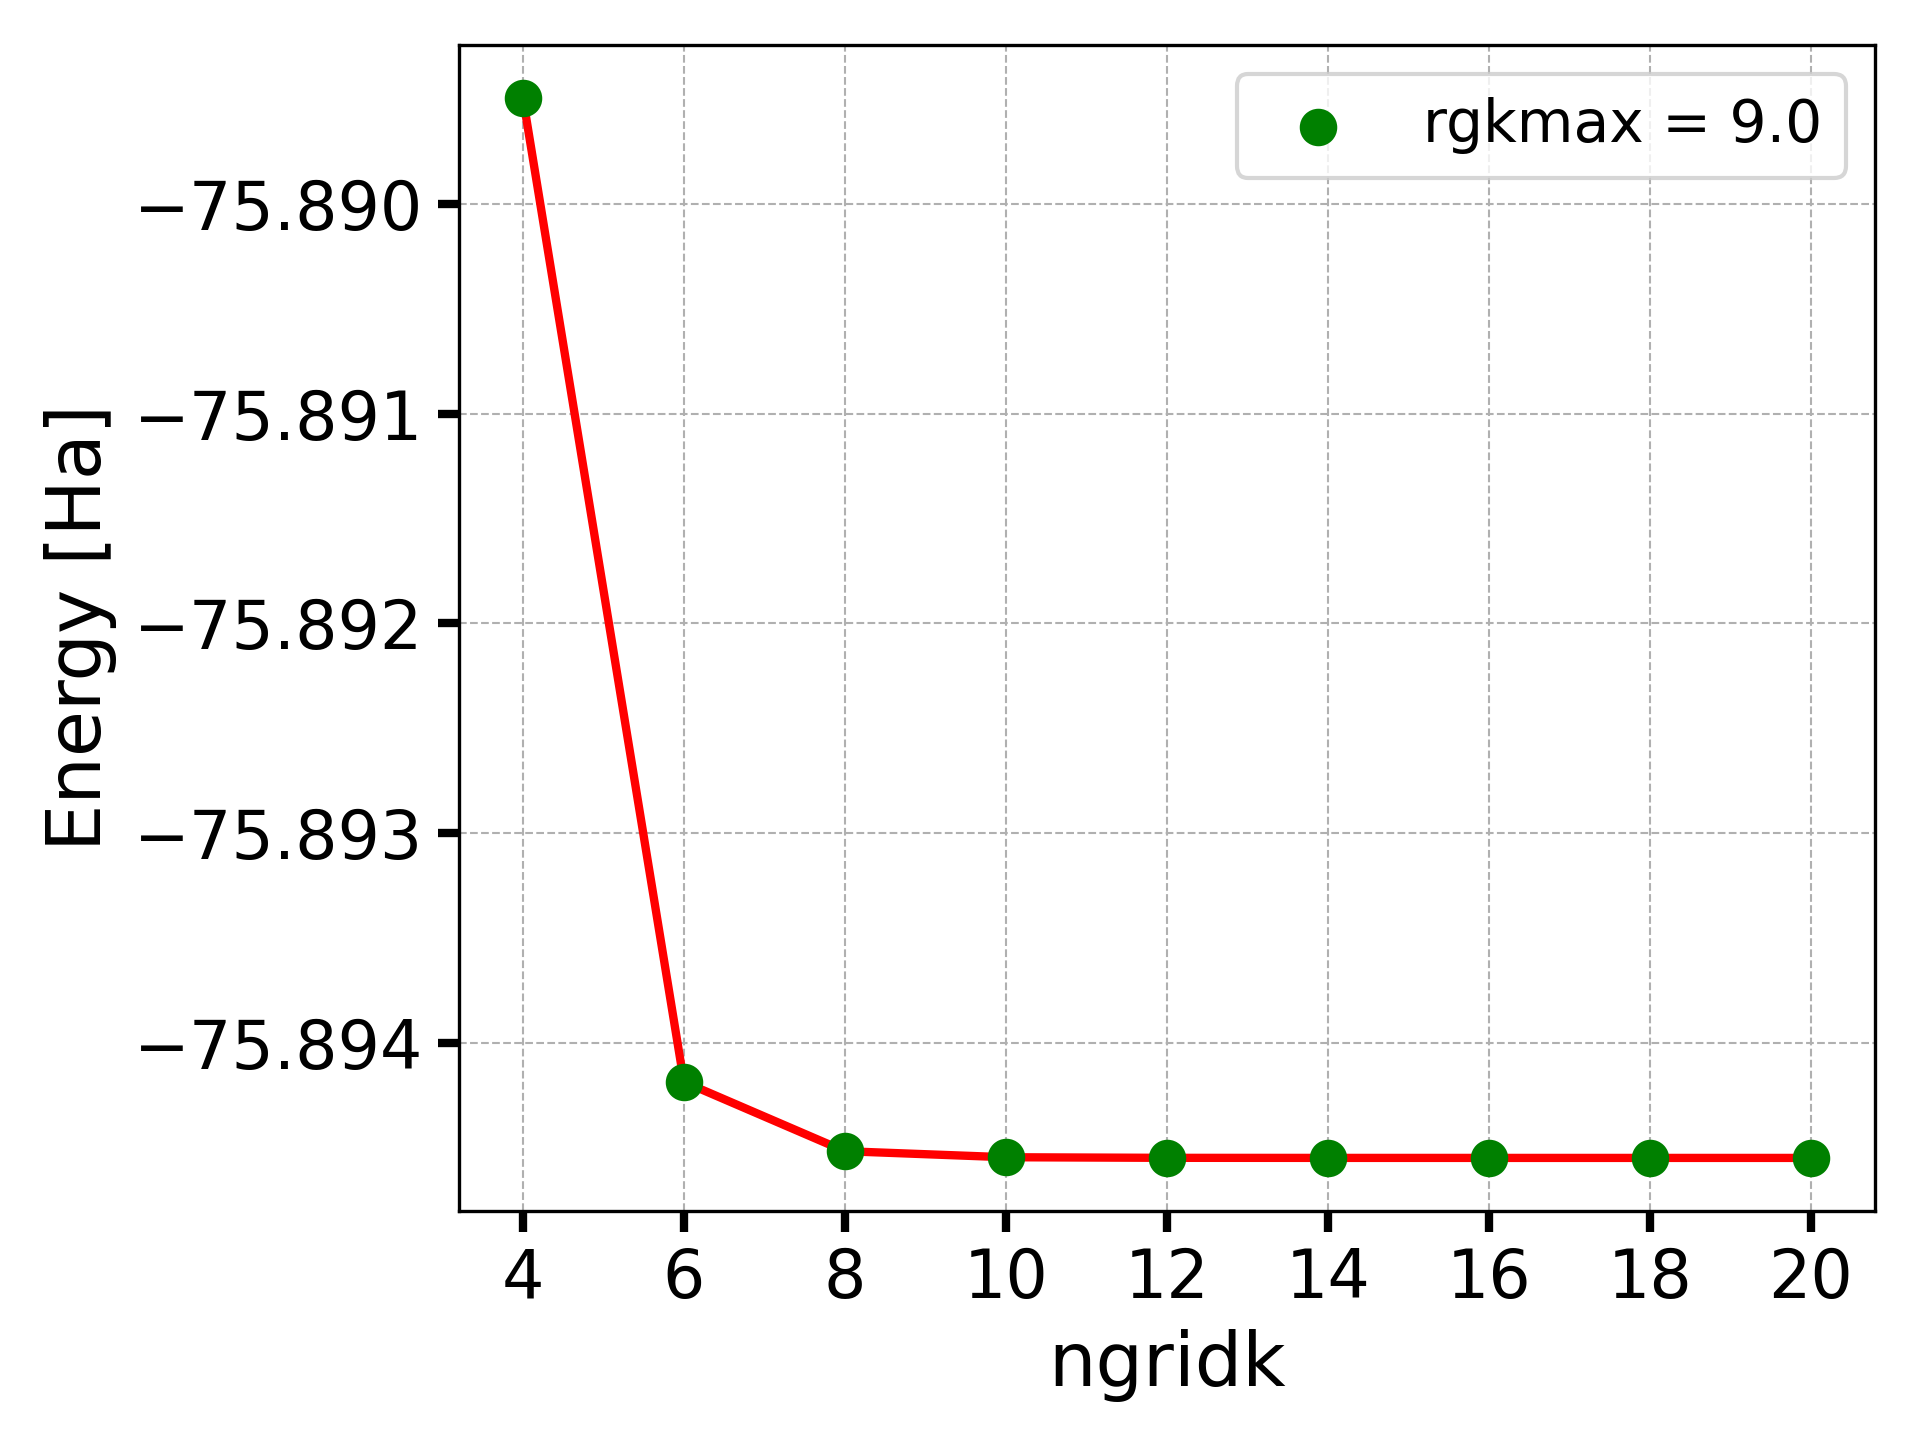" width="500" align="left"/>
</figure>

In [36]:
%%bash
cd reference_data_simple_convergence_tests/diamond_12_12_5_9
python3 -m excitingscripts.plot.convergence r
cd ../..

<figure>
<img src=" 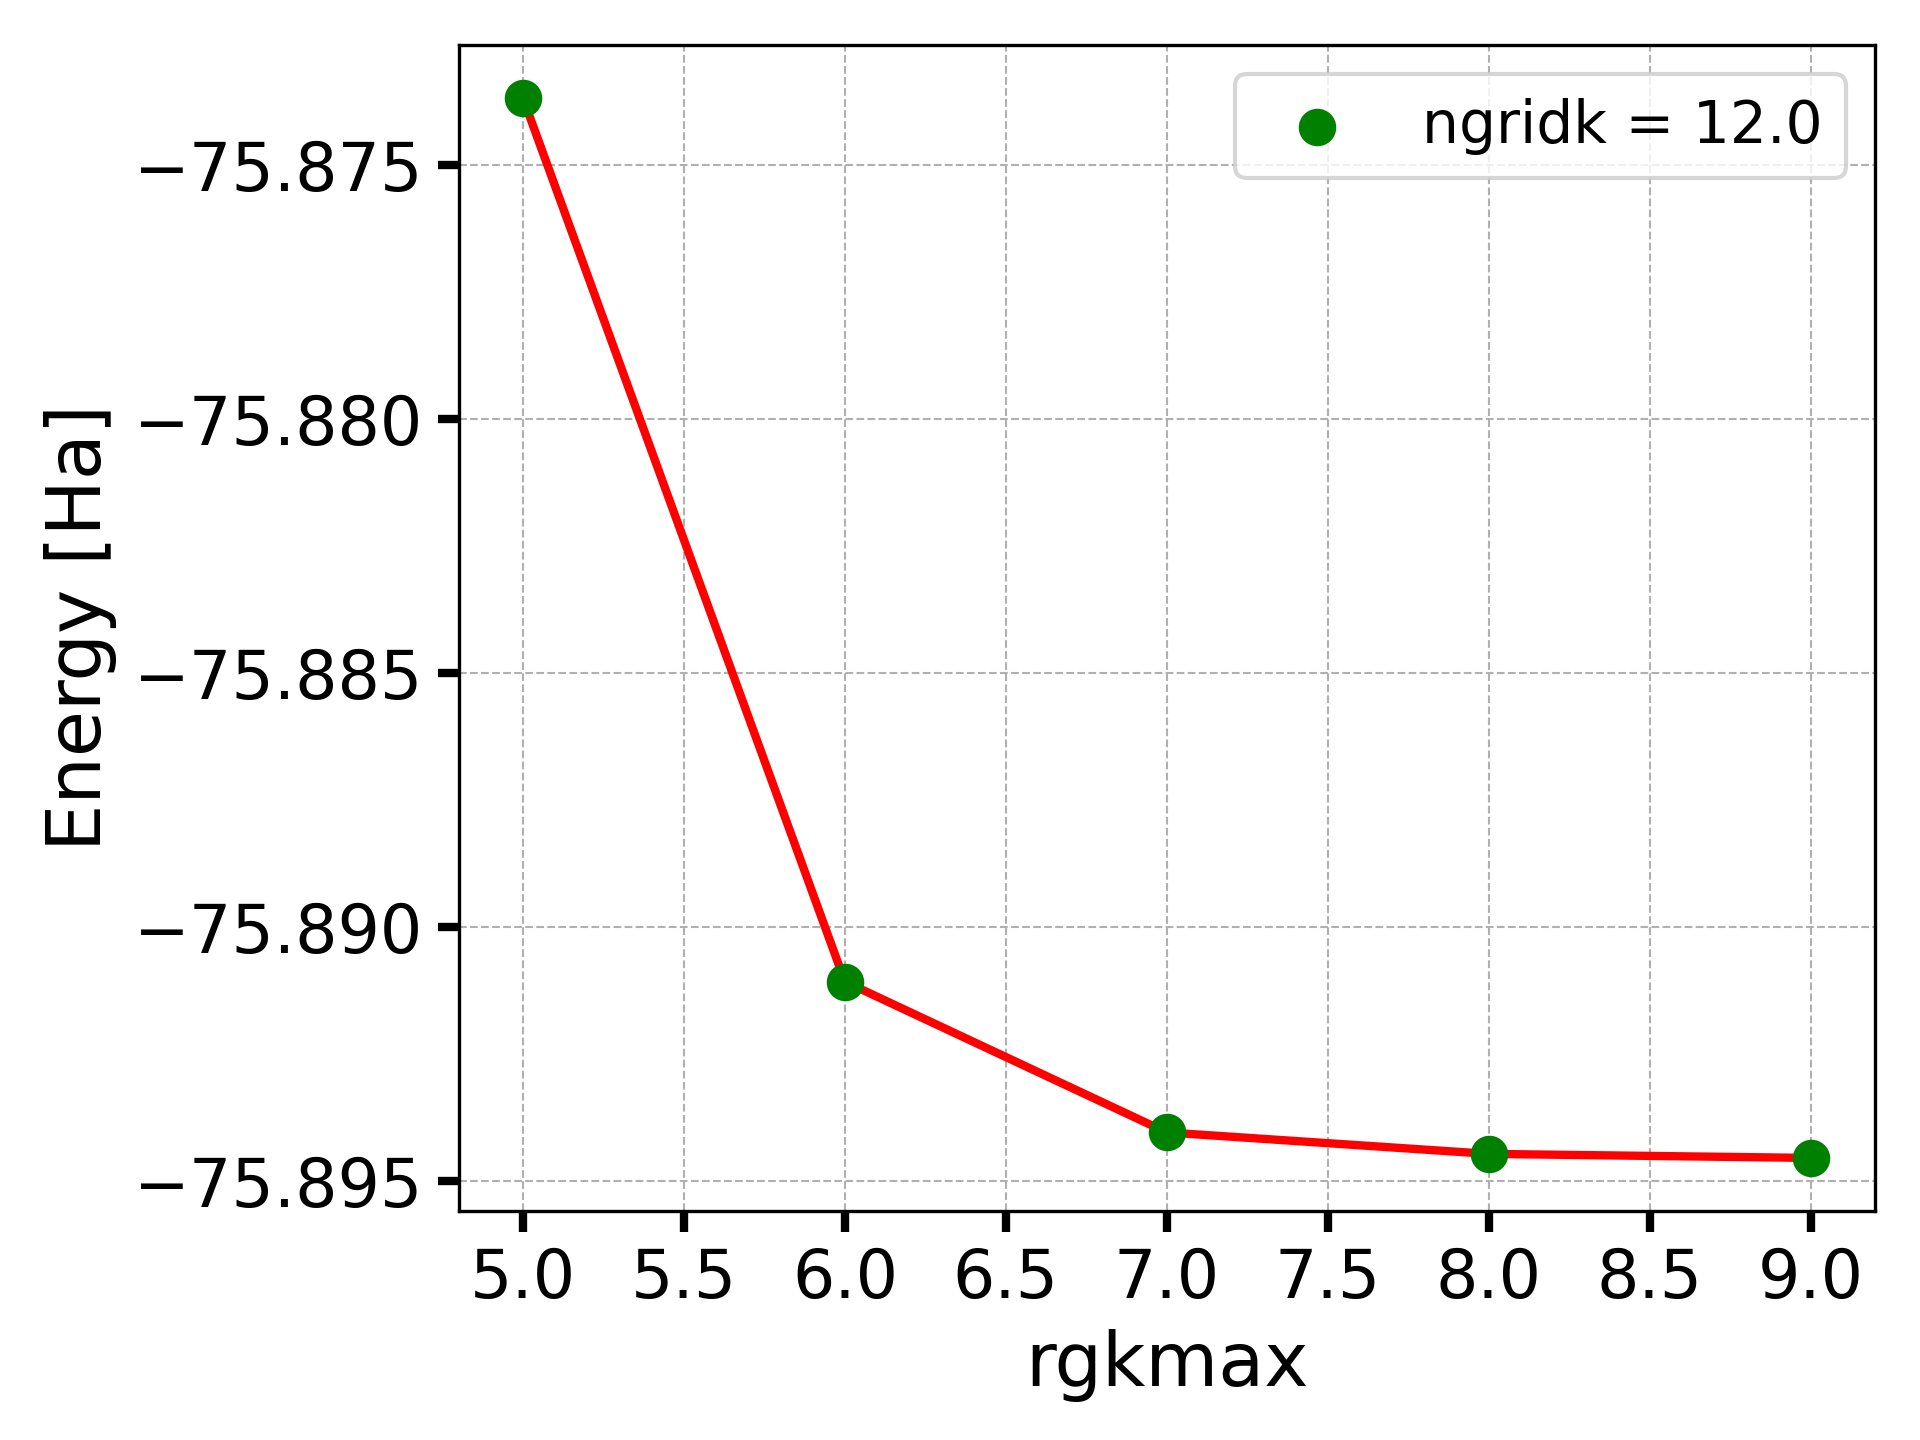" width="500" align="left"/>
</figure>

In [19]:
%%bash
cd reference_data_simple_convergence_tests/diamond_4_20_5_9
python3 -m excitingscripts.plot.convergence rk
cd ../..

<figure>
<img src=" 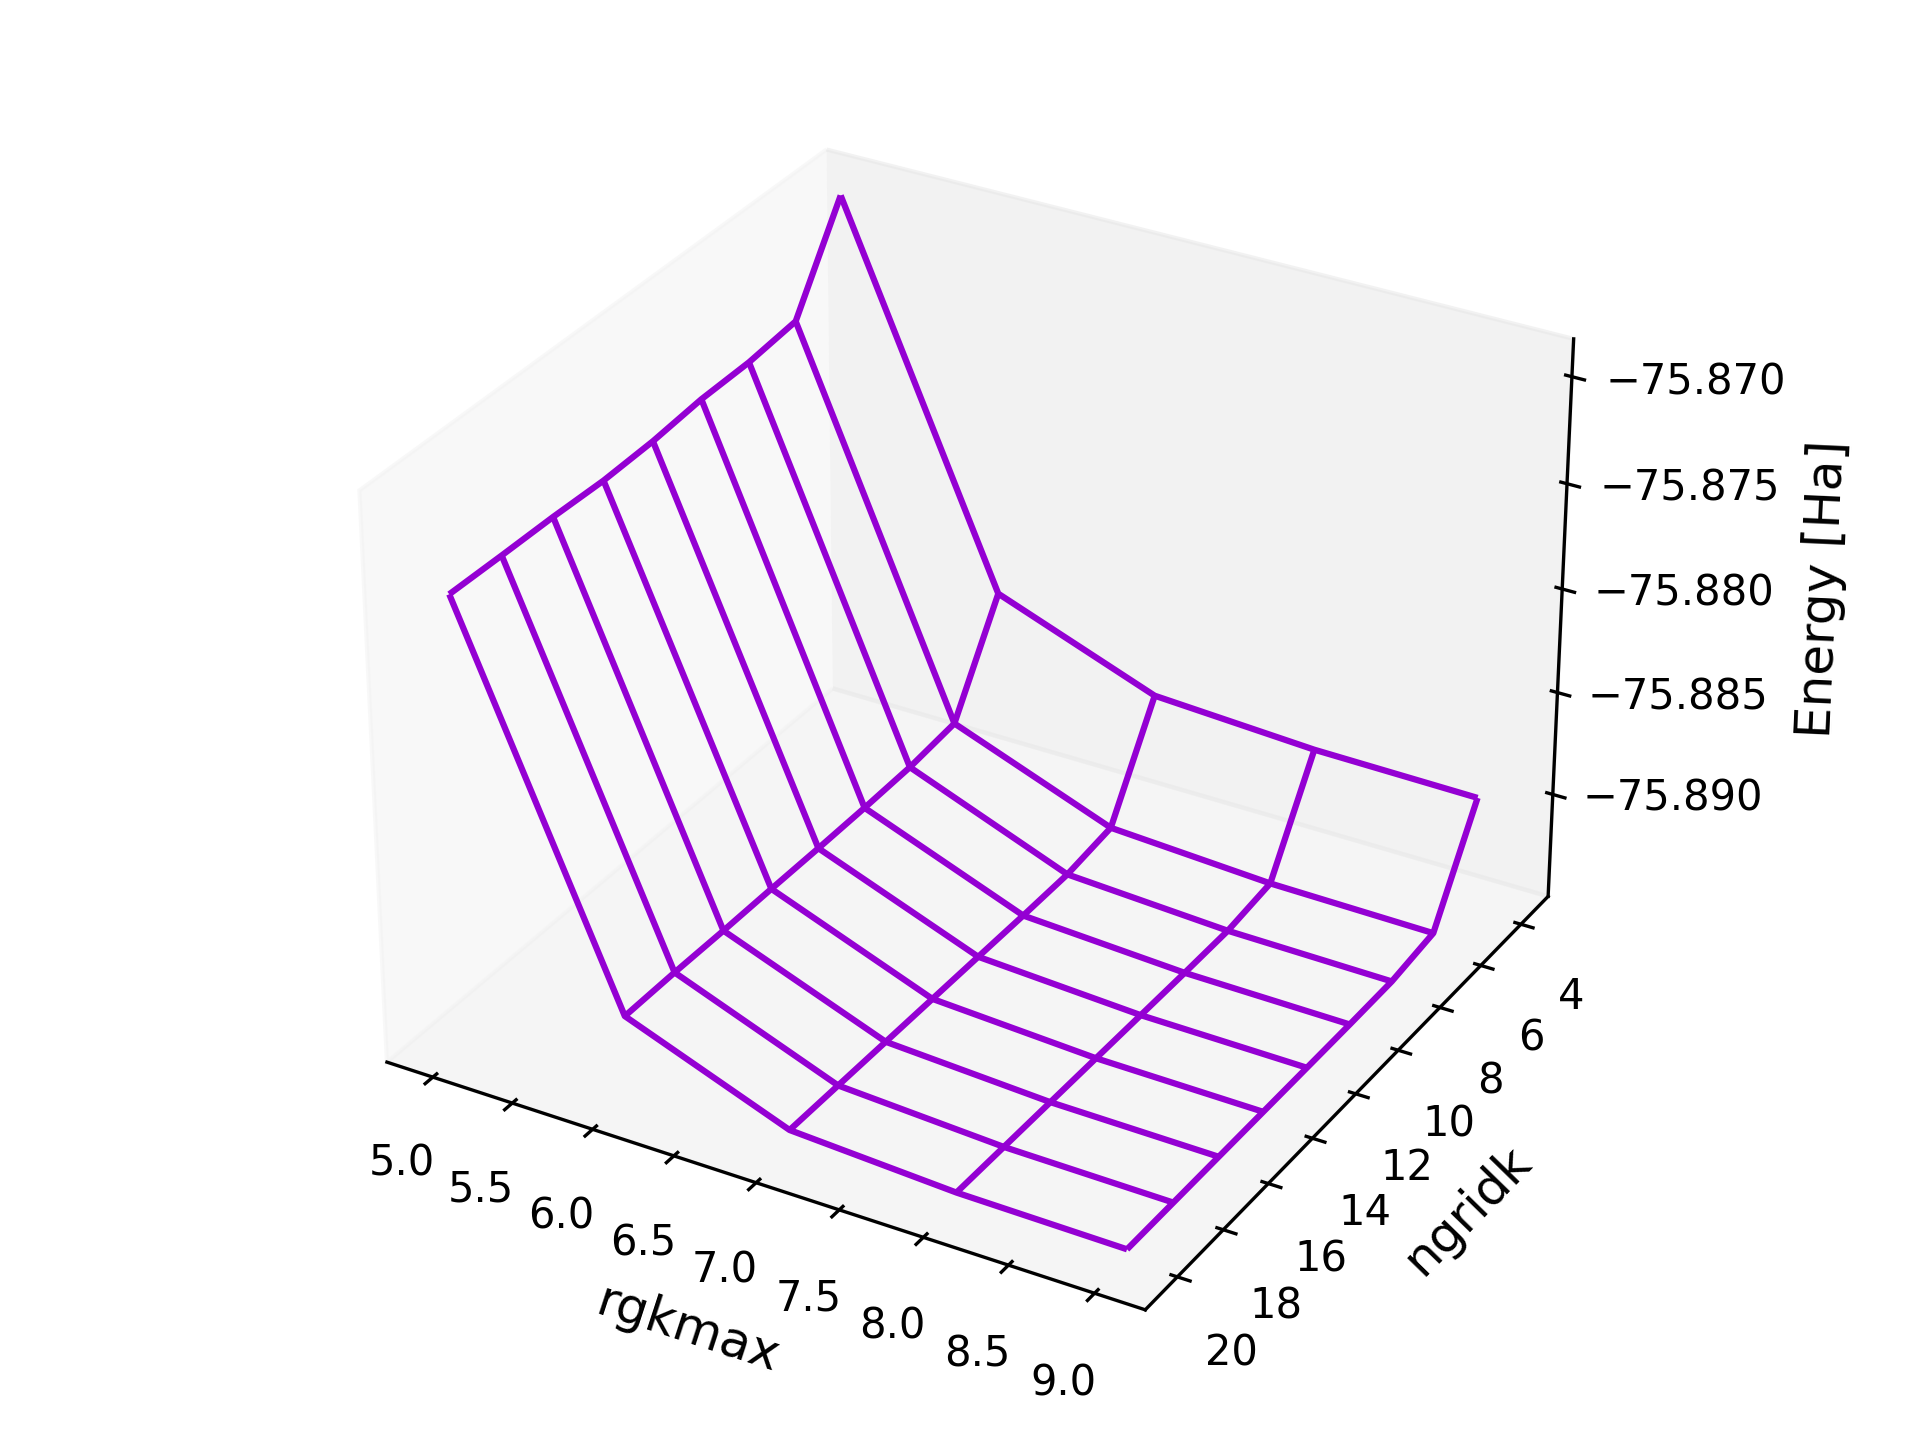" width="600" align="left"/>
</figure>

<a id='4'></a>
<hr style="border:1px solid #DDD"> </hr> 

### <span style="color:#15317E">4. Final Questions</span>

- Is convergence with respect to the values of <code><span style="color:mediumblue">ngridk</span></code> faster for silver or diamond? Why?
- What about the convergence with respect to the values of <code><span style="color:mediumblue">rgkmax</span></code>?

<hr style="border:2px solid #DDD"> </hr>